# Apply Encoding


In [1]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Initialize OneHotEncoder
enc = OneHotEncoder(sparse_output=False) #change to True to get sparse matrix

# Create the input array
X = np.array([['A'], ['B'], ['A'], ['C'], ['B'], ['C']])
print('original matrix')
print(X)

# Fit the encoder and transform the data
enc.fit(X)
result = enc.transform(X)

# Display the result
print('encoded matrix')
print(result)

original matrix
[['A']
 ['B']
 ['A']
 ['C']
 ['B']
 ['C']]
encoded matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [2]:
from dask_ml.preprocessing import OneHotEncoder
import dask.array as da
import numpy as np

# Initialize OneHotEncoder
enc = OneHotEncoder(sparse_output=False)

# Create the input array in dask with 3 chunks of size 2
# The chunks=2 argument specifies that the data will be split 
# into chunks of size 2 along the first axis for parallel processing.
X = da.from_array([['A'], ['B'], ['A'], ['C'], ['B'], ['C']], chunks=2)
print('\noriginal matrix')
print(X) # this will print the dask array
print('\noriginal matrix computed')
print(X.compute()) # this will print the actual data

# Fit the encoder and transform the data
enc = enc.fit(X)
result = enc.transform(X)

# Display the result
print('\nencoded matrix')
print(result) # this will print the dask array
print('\nencoded matrix computed')
print(result.compute()) # this will print the actual data



original matrix
dask.array<array, shape=(6, 1), dtype=<U1, chunksize=(2, 1), chunktype=numpy.ndarray>

original matrix computed
[['A']
 ['B']
 ['A']
 ['C']
 ['B']
 ['C']]

encoded matrix
dask.array<lambda, shape=(6, 3), dtype=float64, chunksize=(2, 3), chunktype=numpy.ndarray>

encoded matrix computed
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


`dask_ml.preprocessing` builds upon the functionality of `scikit-learn` and utilizes the same familiar interfaces, such as `.fit()` and `.transform()`. The key advantage of Dask lies in its ability to handle preprocessing tasks, like `OneHotencoder`, efficiently by processing data in smaller, manageable chunks instead of loading the entire dataset into memory. This makes it especially suited for large datasets that exceed memory limits.

For example, the parameter `chunks=2` specifies that the data will be divided into chunks with size 2 along the first axis (the rows). Each chunk is processed independently and in parallel, improving performance and scalability compared to single-threaded or in-memory operations when your dataset is large.


In [3]:
import dask.array as da
import numpy as np

# Create the input array
X = np.array([['A'], ['B'], ['A'], ['C'], ['B'], ['C']])

# Convert to Dask array with chunksize=2 rows
dask_X = da.from_array(X, chunks=2)

# Inspect the chunks
print("Dask array chunks:")
print(dask_X)

# Visualize each chunk using .blocks (compute directly)
print("\nChunks:")
for i in range(len(dask_X.chunks[0])):  # Iterate over the number of chunks
    print(f"Chunk {i+1}:")
    print(dask_X.blocks[i].compute())

Dask array chunks:
dask.array<array, shape=(6, 1), dtype=<U1, chunksize=(2, 1), chunktype=numpy.ndarray>

Chunks:
Chunk 1:
[['A']
 ['B']]
Chunk 2:
[['A']
 ['C']]
Chunk 3:
[['B']
 ['C']]


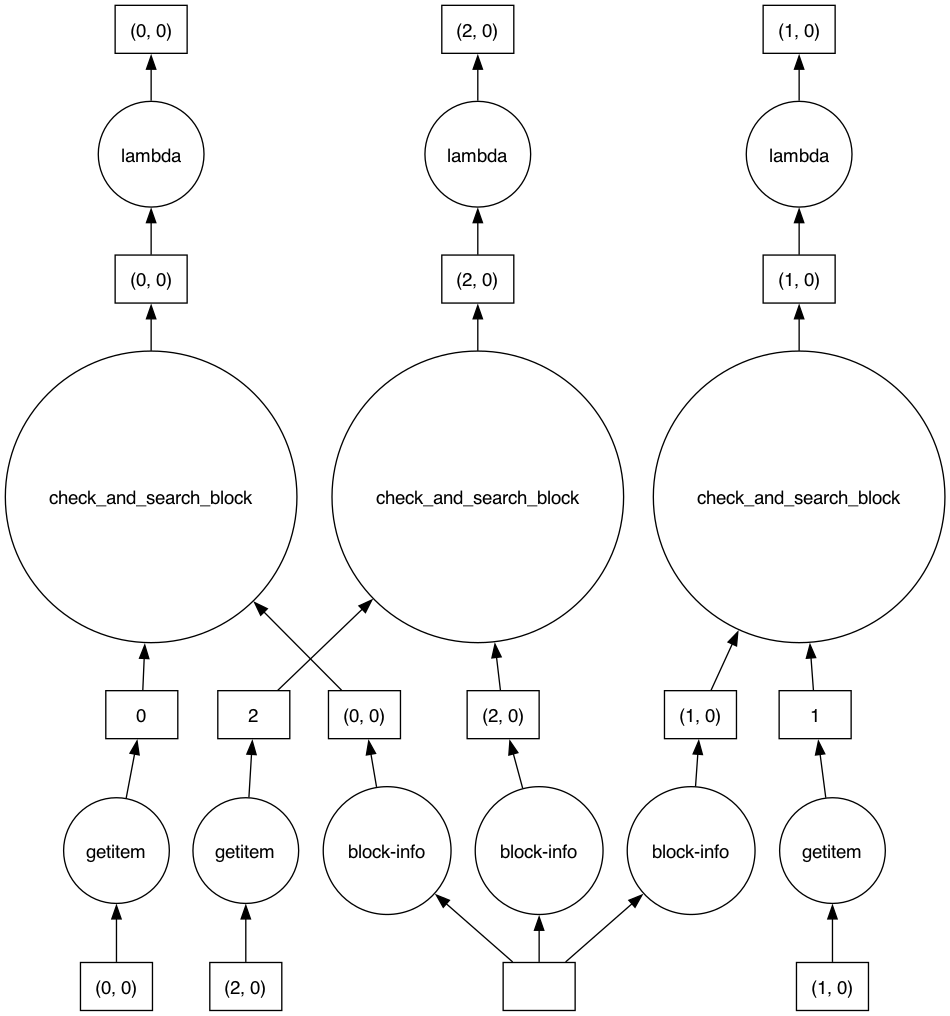

In [4]:
result.visualize()

The data has been split into three chunks along the first axis, labeled (0, 0), (1, 0), and (2, 0). These correspond to portions of the input data. With `getitem` the chunck is retrieved. with `block-info` information about the chunck is retrieved. With `check_and_search_block` is the main computation applied to each chunk. This could be any preprocessing or transformation step. With `lambda` a final transformation or computation is performed on the results from `check_and_search_block`. The output for each chunk is represented by the final rectangles at the top of the graph, labeled (0, 0), (1, 0), and (2, 0).


# Apply scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Example data
data = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9]])

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

# Fit the scaler and transform the data
scaled_data = scaler.fit_transform(data)

# Output the scaled data
print("Scaled Data:")
print(scaled_data)


Scaled Data:
[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]


In `scikit-learn`, the `fit_transform()` method works seamlessly because the entire dataset is loaded into memory. This allows the method to compute global statistics (such as the minimum and maximum values) and immediately apply the transformation in a single step.

In contrast, Dask processes datasets that are typically too large to fit into memory by dividing them into smaller chunks. This chunking introduces a challenge:
1. Global statistics (e.g., min/max) are not immediately available when processing the first chunk.
2. To compute these statistics, Dask must first process all chunks and aggregate their results, which cannot be done while simultaneously applying the transformation.

As a result, Dask separates these operations into two distinct steps: `fit()` and `transform()`. The `fit()` step calculates the necessary global statistics (like min and max) across all chunks, while the `transform()` step applies the transformation based on these pre-computed statistics.

This separation ensures that step is performed independently and in parallel across chunks of data. The intermediate results, like min and max values, are optimized and kept in memory only as needed, avoiding the need to load the entire dataset into memory.


Imagine a dataset with 1 billion rows split into 10 chunks. Here’s how the process works:

#### Step 1: `fit()` (Compute Global Min and Max)
- For each chunk:
  - Chunk 1: Min = 1, Max = 100
  - Chunk 2: Min = 50, Max = 300
  - Chunk 3: Min = 10, Max = 150
  - ...
- Dask combines these results to compute the global min (e.g., 1) and global max (e.g., 300).

#### Step 2: `transform()` (Scale Each Chunk)
- With the global min (1) and max (300) known, Dask scales each chunk independently:
  - Chunk 1: $\frac{X - 1}{300 - 1}$
  - Chunk 2: $\frac{X - 1}{300 - 1}$
  - ...

Each chunk is processed independently, and only the global statistics (e.g., min and max) need to be aggregated, which reduces memory overhead.
Computing local statistics (min/max) and scaling each chunk can happen in parallel across multiple workers or CPUs.
This design allows Dask to work with datasets that are much larger than available memory because it processes one chunk at a time.



In [6]:
import dask.array as da
from dask_ml.preprocessing import MinMaxScaler

# Example Dask array
data = da.from_array([[1, 2, 3],
                      [4, 5, 6],
                      [7, 8, 9]], chunks=1)

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaler.fit(data)      
scaled_data = scaler.transform(data)

# Compute and display the result
print("Scaled Data:")
print(scaled_data)
print(scaled_data.compute())


Scaled Data:
dask.array<add, shape=(3, 3), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]


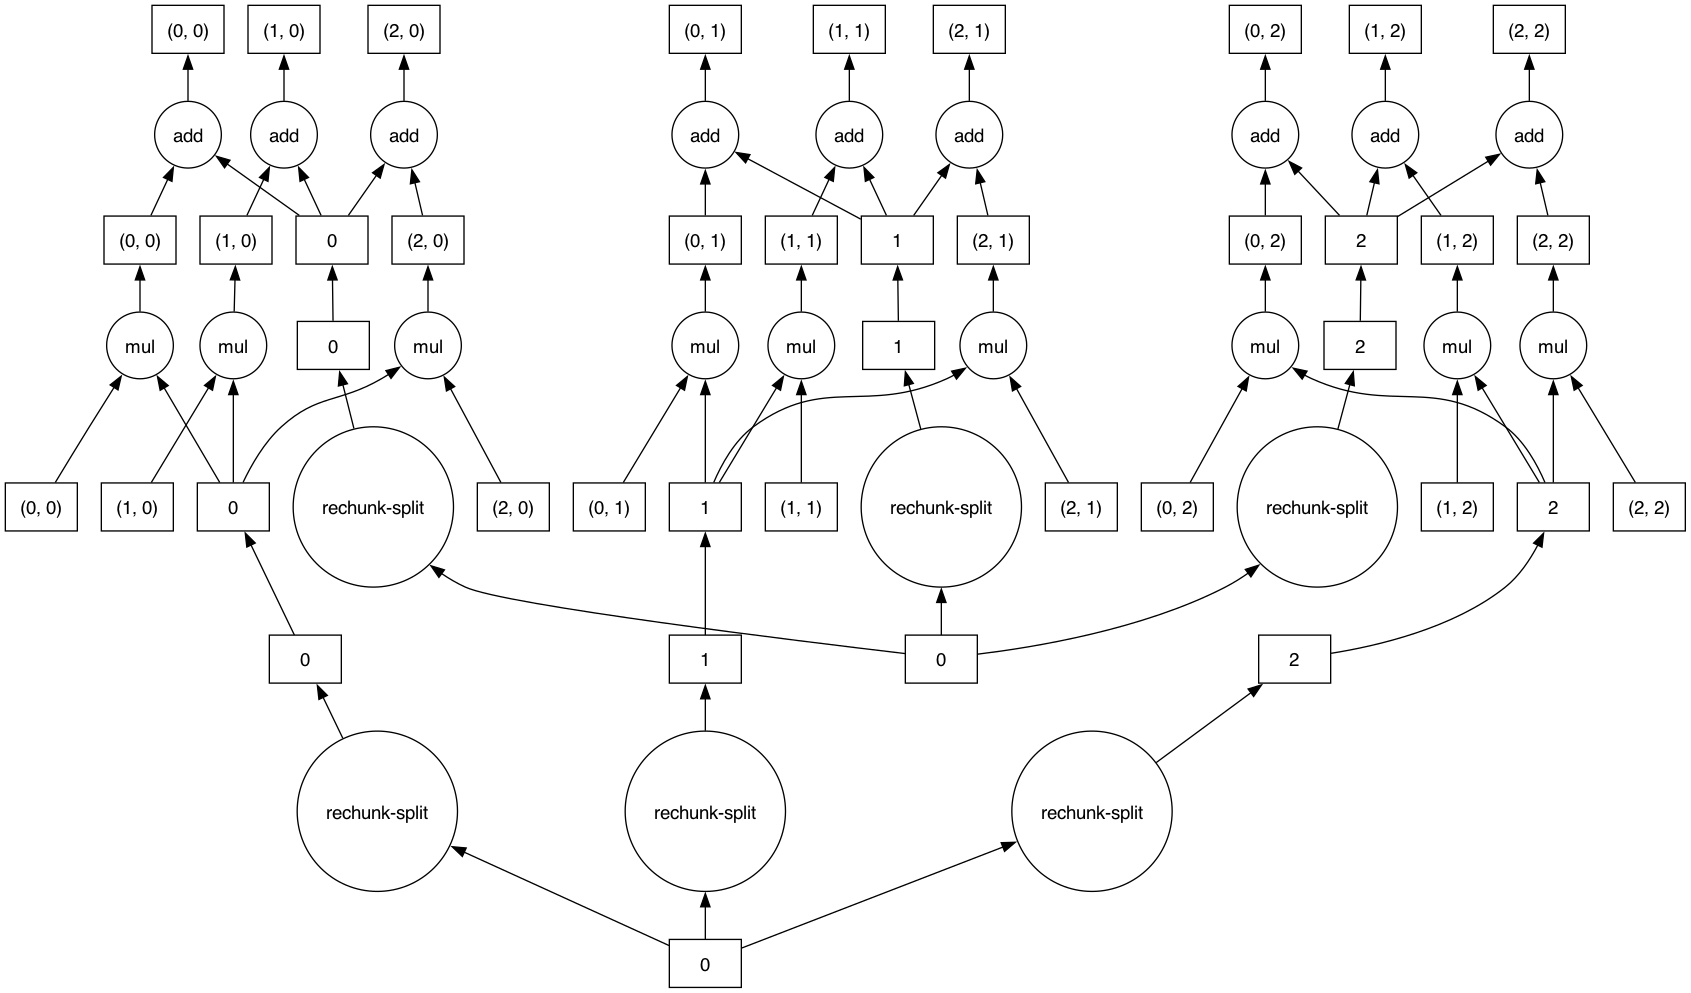

In [7]:
scaled_data.visualize()

In [8]:
# Visualize each chunk using .blocks (compute directly)
print("\nChunks:")
for i in range(len(data.chunks[0])):  # Iterate over the number of chunks
    print(f"Chunk {i+1}:")
    print(data.blocks[i].compute())

# Visualize each chunk using .blocks (compute directly)
print("\nChunks:")
for i in range(len(scaled_data.chunks[0])):  # Iterate over the number of chunks
    print(f"Chunk {i+1}:")
    print(scaled_data.blocks[i].compute())




Chunks:
Chunk 1:
[[1 2 3]]
Chunk 2:
[[4 5 6]]
Chunk 3:
[[7 8 9]]

Chunks:
Chunk 1:
[[0. 0. 0.]]
Chunk 2:
[[0.5 0.5 0.5]]
Chunk 3:
[[1. 1. 1.]]


# Split data

The train_test_split function from dask_ml.model_selection is used to split Dask DataFrames or arrays into random train and test subsets. This function is similar to the train_test_split function from sklearn.model_selection, but it works with Dask collections (dask arrays, dask dataframes, dask bag)
The `train_test_split` method in Dask-ML is partition-aware, splitting data within each partition to avoid costly shuffling and improve performance in distributed environments.

In [12]:
import pandas as pd
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split

# Create a sample Dask DataFrame
data = {
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'feature2': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    'target': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
}
# Mind you For some Dask-ML functions you still need to also call ddf.to_dask_array() 
# in order to convert a DataFrame to an array before training

df = dd.from_pandas(pd.DataFrame(data), npartitions=2)

# Split the DataFrame into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Compute and display the results
print("Training Set:")
print(train.compute())

print("\nTesting Set:")
print(test.compute())


Training Set:
   feature1  feature2  target
0         1        10       0
1         2         9       1
2         3         8       0
3         4         7       1
5         6         5       1
6         7         4       0
7         8         3       1
8         9         2       0
9        10         1       1

Testing Set:
   feature1  feature2  target
4         5         6       0


/Users/lytsding/opt/miniconda3/envs/chemdata/lib/python3.10/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(
